# Machine Learning and Computational Statistics
# Homework 1: Ridge Regression, Gradient Descent, SGD

In [1]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Assignment Owner: Tian Wang

## Normalization

When features differ greatly, we can get much slower rates of convergence of gradient-based algorithms. Furthermore, when we start using regularization, features with larger values are treated as 'more important', which is not usually what you want. One common approach to feature normalization is to perform an affine transformation (i.e. shift and rescale) on each feature so that all feature values in the training set are in \[0,1\]. Each feature gets its own transformation. We then apply the same transformations to each feature on the test set.  
It's important that the transformation is 'learned' on the training set, and then applied to the test set. It is possible that some transformed test set values will lie outside of the \[0,1\] intervall.  
Modify function feature_normalization to normalize all the features to \[0,1\]. Note that a feature with constant value cannot be normalized in this way. Your function should discard features that are constant in the training set.

In [2]:
def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    train_normalized = (train - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    test_normalized = (test - train.min(axis=0))/(train.max(axis=0)-train.min(axis=0))
    return (train_normalized, test_normalized)

## Gradient Descent Setup

In linear regression, we consider the hypothesis space of linear functions $h_\theta : R^d \to R$, where  
  
$$h_\theta(x) = \theta^Tx,$$  
  
for $\theta, x \in R^d$, and we choose  $\theta$ that minimizes the following “square loss” objective function:  

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^n (h_\theta(x_i)−y_i)^2,$$  

where $(x_1, y_1), ..., (x_m, y_m) \in R^d \times R$ is our training data.
While this formulation of linear regression is very convenient, it’s more standard to use a hypothesis space of “affine” functions:
$$h_\theta(x) = \theta^Tx + b,$$  

which allows a “bias” or nonzero intercept term. The standard way to achieve this, while still maintaining the convenience of the first representation, is to add an extra dimension to x that is always a fixed value, such as 1. You should convince yourself that this is equivalent. We’ll assume this representation, and thus we’ll actually take  $\theta, x \in R^{d+1}$.

1. Let $X \in R^{m\times(d+1)}$ be the design matrix, where the *i*’th row of $X$ is $x_i$. Let $y = (y_1, ...,y_m)^T \in R^{m\times1}$ be the “response”. Write the objective function $J(\theta)$ as a matrix/vector expression, without using an explicit summation sign.

$$J(\theta) = \frac{1}{m} (X\theta - y)^T(X\theta-y)$$

2. Write down an expression for the gradient of J

Using the chain rule: if $ h(x) = f(g(x)) $, then $ h'(x) = f'(g(x))\cdot g'(x) $  

$$ \nabla J(\theta) = \frac{2}{m}(X\theta - y)X $$

3. In our search for a $\theta $ that minimizes J, suppose we take a step from $\theta$ to $\theta + \eta h$, where $h \in R^{d+1}$ is the “step direction” (recall, this is not necessarily a unit vector) and $\eta \in (0, \infty)$ is the “step size” (note that this is not the actual length of the step, which is $\eta \| h\|$). Use the gradient to write down an approximate expression for the change in objective function value $J(\theta + \eta h) - J(\theta)$ This approximation is called a “linear” or “first-order” approximation.

We have: $$ \nabla J(\theta, h) = \lim\limits_{\eta \to 0} \frac {J(\theta + \eta h)- J(\theta)}{\eta}$$
  
Therefore:
$J(\theta + \eta h) - J(\theta) \approx \eta \nabla J(\theta,h) $

4. Write down the expression for updating $\theta$ in the gradient descent algorithm. Let $\eta$ be the step size.

$\theta = \theta - \eta \nabla J(\theta) $
  
We 'take a step' (change $\theta$) in the direction of fastest decrease of the objective function $J(\theta)$

### The square loss function

In [3]:
def compute_square_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss
    
    m = len(y)
    loss = (1/(m))*np.transpose((X@theta - y))@(X@theta - y)
    
    return loss

### Square loss gradient

In [4]:
### compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    m = len(y)
    grad = (2/m)*np.transpose(X)@(X@theta - y)
    
    
    return grad


## Gradient checker

Getting the gradient calculation correct is often the trickiest part of any gradient-based optimization algorithm.  Fortunately, it's very easy to check that the gradient calculation is correct using the definition of gradient.
See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization

If $J: R^d \to R$ is differentiable, then for any vector $h \in R^d$, the directional derivative of $J$ at $\theta$ in the direction $h$ is given by: 
$$ \lim\limits_{\varepsilon \to 0} \frac {J(\theta + \varepsilon h)- J(\theta - \varepsilon h)}{2\varepsilon}.$$

We can approximate this directional derivative by choosing a small value of $\varepsilon > 0$ and evaluating the quotient above. We can get an approximation to the gradient by approximating the directional derivatives in each coordinate direction and putting them together into a vector. In other words, take $h = (1, 0, 0,... ,0)$ to get the first component of the gradient. Then take $h = (0, 1, 0,... ,0)$ to get the second component. And so on.

1. Complete the function grad_checker according to the documentation given. Alternatively, you may complete the function generic_grad_checker so that it works for any objective function. It should take as parameters a function that computes the objective function and a function that computes the gradient of the objective function. Note: Running the gradient checker takes extra time. In practice, once you’re convinced your gradient calculator is correct, you should stop calling the checker so things run faster.

In [5]:
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4):
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in range(num_features):
        approx_grad[i] = (compute_square_loss(X, y, theta[i] + epsilon) - compute_square_loss(X, y, theta[i] - epsilon)) / (2*epsilon)
    
    
    dist = np.linalg.norm(true_gradient-approx_grad)
    
    if dist > tolerance:
        return False
    else:
        return True

## Generic Gradient Checker

In [6]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) 
    returned the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in range(num_features):
        approx_grad[i] = (objective_func(X, y, theta[i] + epsilon) - objective_func(X, y, theta[i] - epsilon)) / (2*epsilon)
    
    
    dist = np.linalg.norm(true_gradient-approx_grad)
    
    if dist > tolerance:
        return False
    else:
        return True


## Batch Gradient Descent

In [7]:
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.zeros(num_features) #initialize theta
    
    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0, :] = theta[:]
    
    for i in range(1, num_iter+1):
        theta = theta - (alpha)*compute_square_loss_gradient(X, y, theta)
        
        theta_hist[i, :] = theta[:]
        loss_hist[i] = compute_square_loss(X, y, theta)
    
    return theta_hist, loss_hist

In [8]:
data = pd.read_csv('data.csv')
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.951051,-0.951051,-4.755257,-0.866019,-0.866019,-4.330093,-0.781824,-0.781824,-3.909121,-1.376575
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.948871,-0.948871,-4.744353,-0.863095,-0.863095,-4.315474,-0.778705,-0.778705,-3.893525,0.878782
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.948056,-0.948056,-4.740279,-0.862011,-0.862011,-4.310053,-0.777551,-0.777551,-3.887757,1.108701
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.941999,-0.941999,-4.709996,-0.854081,-0.854081,-4.270406,-0.769161,-0.769161,-3.845805,0.519229
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.939440,-0.939440,-4.697202,-0.850794,-0.850794,-4.253972,-0.765706,-0.765706,-3.828531,0.772872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.036417,-0.036417,-0.182083,-0.030349,-0.030349,-0.151746,-0.026015,-0.026015,-0.130073,2.503566
196,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.036086,-0.036086,-0.180430,-0.030074,-0.030074,-0.150368,-0.025778,-0.025778,-0.128892,2.414250
197,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.007125,-0.007125,-0.035624,-0.005937,-0.005937,-0.029687,-0.005089,-0.005089,-0.025446,3.379356
198,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.004506,-0.004506,-0.022530,-0.003755,-0.003755,-0.018775,-0.003219,-0.003219,-0.016093,2.468850


In [9]:
################################################
### Visualization that compares the convergence speed of batch
###and stochastic gradient descent for various approaches to step_size
##X-axis: Step number (for gradient descent) or Epoch (for SGD)
##Y-axis: log(objective_function_value) and/or objective_function_value


#Loading the dataset
print('loading the dataset')

df = pd.read_csv('data.csv', delimiter=',')
X = df.values[:,:-1]
y = df.values[:,-1]

print('Split into Train and Test')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

print("Scaling all to [0, 1]")
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


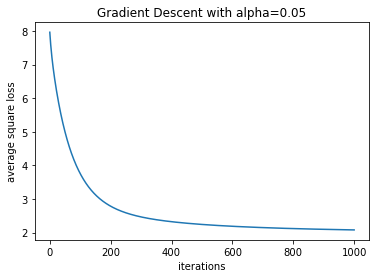

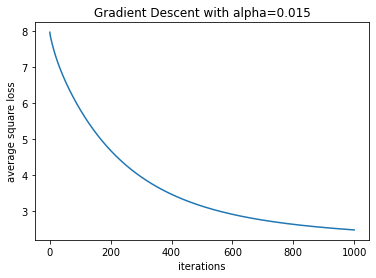

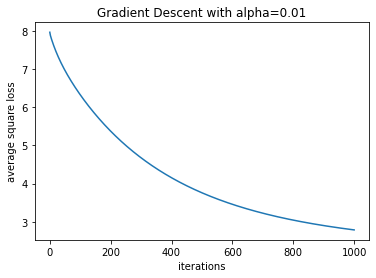

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()


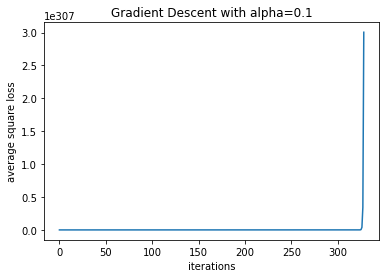

In [10]:
for alpha in [5.0e-2, 1.5e-2, 1.0e-2, 1.0e-1]:
        theta_hist, loss_hist = batch_grad_descent(X_train, y_train, alpha=alpha, num_iter=1000)
        
        plt.xlabel('iterations')
        plt.ylabel('average square loss')
        plt.title('Gradient Descent with alpha=%s' % str(alpha))
        plt.plot([i for i in range(1001)], loss_hist)
        plt.show()

## Ridge regression (i.e. Linear Regression with $l_2$ regularization)

When we have a large number of features compared to instances, regularization can help control overfitting.  
Ridge regression is linear regression with $l_2$ regularization. The regularization term is sometimes called a penalty term.  
The objective function (loss function) for ridge regression is: $$ J(\theta) = \frac{1}{m} \sum_{i=1}^n (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta,$$ where $\lambda$ is the regularization parameter, which controls the degree of regularization.  

Gradient of J(θ):

$$ J(\theta) = \frac{1}{m}(\theta X − y)^T(\theta X − y) + \lambda\theta^T\theta$$
$$ \nabla J(\theta) = \frac{2}{m}X^T(\theta X − y) + 2\lambda\theta$$

In [11]:
####################################
###Q2.4b: Implement backtracking line search in batch_gradient_descent
###Check http://en.wikipedia.org/wiki/Backtracking_line_search for details
#TODO

In [12]:
###################################################
### Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    #TODO
    loss = 0 #initialize the square_loss
    
    m = len(y)
    grad = (2/m)*np.transpose(X)@(X@theta - y) + 2*lambda_reg*theta
    
    return grad

    

In [13]:
###################################################
### Batch Gradient Descent with regularization term
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run

    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features)
        loss_hist - the history of loss function without the regularization term, 1D numpy array.
    """
    (num_instances, num_features) = X.shape
    theta = np.zeros(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    #TODO
    
    loss_hist[0] = compute_square_loss(X, y, theta)
    theta_hist[0, :] = theta[:]
    
    for i in range(1, num_iter+1):
        theta = theta - (alpha)*compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        
        theta_hist[i, :] = theta[:]
        loss_hist[i] = compute_square_loss(X, y, theta) + lambda_reg*np.transpose(theta)@theta
    
    return theta_hist, loss_hist

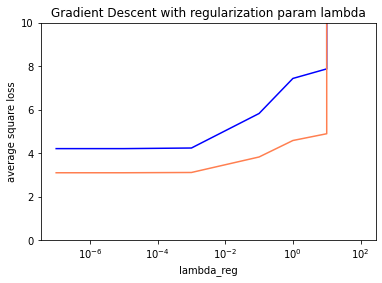

In [14]:
avg_loss_train=[]
avg_loss_test=[]
for lambda_reg in [1.0e-7, 1e-5, 1.0e-3, 1.0e-1, 1, 10, 100]:
        theta_hist_train, loss_hist_train = regularized_grad_descent(X_train, y_train, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        theta_hist_test, loss_hist_test = regularized_grad_descent(X_test, y_test, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        avg_loss_train.append(np.mean(loss_hist_train))
        avg_loss_test.append(np.mean(loss_hist_test))
        

lambda_reg = [1.0e-7, 1e-5, 1.0e-3, 1.0e-1, 1, 10, 100]
        
plt.xlabel('lambda_reg')
plt.ylabel('average square loss')
plt.title('Gradient Descent with regularization param lambda')
plt.semilogx(lambda_reg, avg_loss_train, c = 'blue')
plt.semilogx(lambda_reg, avg_loss_test, c = 'coral')
plt.ylim(0,10)
plt.show()

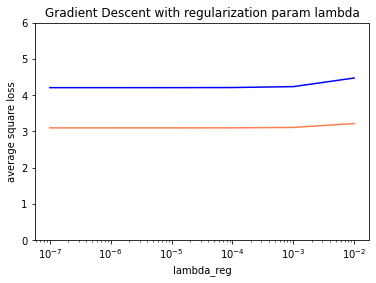

In [20]:
avg_loss_train=[]
avg_loss_test=[]
for lambda_reg in [1.0e-7, 1e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]:
        theta_hist_train, loss_hist_train = regularized_grad_descent(X_train, y_train, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        theta_hist_test, loss_hist_test = regularized_grad_descent(X_test, y_test, alpha=0.01, lambda_reg=lambda_reg, num_iter=1000)
        avg_loss_train.append(np.mean(loss_hist_train))
        avg_loss_test.append(np.mean(loss_hist_test))        

lambda_reg = [1.0e-7, 1e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]
        
plt.xlabel('lambda_reg')
plt.ylabel('average square loss')
plt.title('Gradient Descent with regularization param lambda')
plt.semilogx(lambda_reg, avg_loss_train, c = 'blue')
plt.semilogx(lambda_reg, avg_loss_test, c = 'coral')
plt.ylim(0,6)
plt.show()

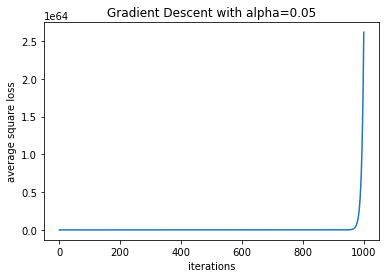

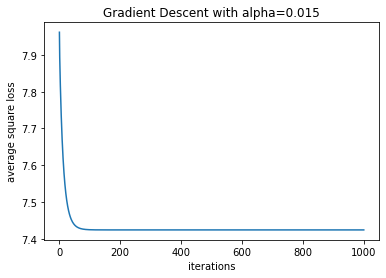

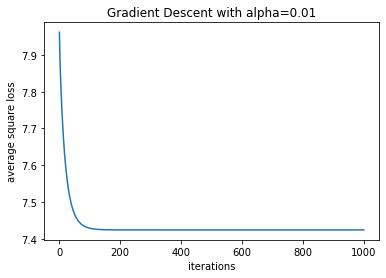

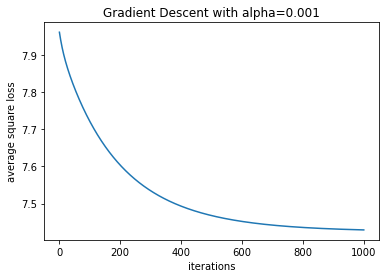

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in matmul
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in matmul
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in matmul
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2234: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


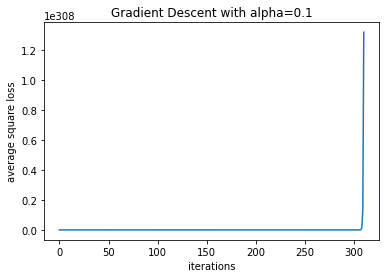

In [16]:
for alpha in [5.0e-2, 1.5e-2, 1.0e-2, 1e-3, 1.0e-1]:
        theta_hist, loss_hist =  regularized_grad_descent(X_train, y_train, alpha=alpha, num_iter=1000)
        
        plt.xlabel('iterations')
        plt.ylabel('average square loss')
        plt.title('Gradient Descent with alpha=%s' % str(alpha))
        plt.plot([i for i in range(1001)], loss_hist)
        plt.show()

## Stochastic Gradient Descent

When the training data set is very large, evaluating the gradient of the objective function can take a long time, since it requires looking at each training example to take a single gradient step. When the objective function takes the form of an average of many values, such as: $$ J(\theta) = \frac{1}{m} \sum_{i=1}^m f_i(\theta) $$ (as it does in the empirical risk), stochastic gradient descent (SGD) can be very effective.  
In SGD, rather than taking $-\nabla J(\theta)$ as our step direction, we take $-\nabla f_i(\theta)$ for some $i$ chosen uniformly at random {_1,...,m_}. The approximation is poor, but we will show it is unbiased.  
  
In ML applications, each $ f_i(\theta)$ would be the loss on the *i*th example (and of course we'd typically write *n* instead of *m*, for the number of training points). In practical implementations for ML, the data points are **randomly shuffled**, and then we sweep through the whole training set one by one, and perform an update for each training example individually. One pass through the data is called an **epoch**. Note that each epoch of SGD touches as much data as a single step of batch gradient descent. You can use the same ordering for each epoch, tough optionally you could investigate wehter reshuffling after each epoch affects the convergence speed.

1. Show that the objective function $$ J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta,$$ can be written in the form $ J(\theta) = \frac{1}{m} \sum_{i=1}^m f_i(\theta) $ by giving an expression for $f_i(\theta)$ that makes the two expressions equivalent.

We can write:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [(h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta]$$  
since when we sum up $\lambda\theta^T\theta$ we obtain $m\lambda\theta^T\theta$, which is equal to $\lambda\theta^T\theta$ when multiplied by $\frac{1}{m}$  
Therefore $f_i(\theta) = (h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta$

2. Show that the stochastic gradient $\nabla f_i(\theta)$ for some $i$ chosen uniformly at random from {_1,...,m_}, is an **unbiased estimator** of $\nabla J(\theta)$. In other words, show that $\mathop{\mathbb{E}}[\nabla f_i(\theta)]= \nabla J(\theta)$ for any $\theta$.

$\mathop{\mathbb{E}}[\nabla f_i(\theta)]= \nabla \mathop{\mathbb{E}} f_i(\theta)$  

$= \nabla (\sum_{j=1}^N P(i=j)f_j(\theta))  $  

$= \nabla (\frac{1}{N} \sum_{j=1}^N f_j(\theta))  $  

$= \nabla J(\theta) $
  
This means that if we use the Stochastic Gradient repeatedly, over time it will give us the same results as using the full Batch Gradient we have been using! (definition of expectation of a function) 

3. Write down the update rule for $\theta$ in SGD for the ridge regression objective function

$\theta = \theta - \nabla f_i(\theta)$

$ \nabla f_i(\theta) = \nabla [(h_\theta(x_i)−y_i)^2 + \lambda\theta^T\theta]$  
  
Chain rule:
  
$ = 2h_\theta(x_i) - y_i)\nabla h_\theta(x_i) + 2\lambda\theta$
  
We have: 
  
$ \nabla h_\theta(x_i) = \nabla \theta^T x_i = x_i $
  
$ \nabla f_i(\theta) = 2(h_\theta(x_i) - y_i)x_i + 2\lambda\theta$
  
$ = 2[(h_\theta(x_i) - y_i)x_i + \lambda\theta] $

In [17]:
#############################################
### Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=0.01, num_iter=1000):
    """
    In this question you will implement stochastic gradient descent with a regularization term

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set

    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features)
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta


    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    #TODO
    for j in range(num_iter):
        
        # Reshuffle indices to for new epoch, so we get new random points at each iteration
        shuffled_indices = np.random.permutation(num_instances)
        
        for i in shuffled_indices:
        
        
            loss_SGD = (np.transpose((X[i,:]@theta - y[i]))*(X[i,:]@theta - y[i])) + lambda_reg*np.transpose(theta)@theta
            loss_hist[j,i] = loss_SGD
            grad_SGD = 2*((X[i,:]@theta - y[i])*X[i] + lambda_reg*theta)
            theta = theta - alpha*grad_SGD
            theta_hist[j,i,:] = theta
    
    
    
    return theta_hist, loss_hist

In [18]:
stochastic_grad_descent(X_train, y_train, alpha=0.01, lambda_reg=0.1, num_iter=1000)

(array([[[-2.67679012e-01, -1.62579371e-01, -1.29494571e-01, ...,
           5.08163855e-02,  5.08163855e-02, -3.10608631e-01],
         [-2.71226952e-01,  4.20699746e-02,  2.46013011e-01, ...,
           1.45060716e-01,  1.45060716e-01, -3.74194509e-01],
         [-1.97926588e-01, -9.19819285e-02, -5.86311218e-02, ...,
           9.24230107e-02,  9.24230107e-02, -2.41201368e-01],
         ...,
         [-2.60447061e-01, -1.54077349e-01, -1.20592738e-01, ...,
           3.75058647e-02,  3.75058647e-02, -3.03895462e-01],
         [-4.98594815e-02,  7.97024089e-04,  7.97024089e-04, ...,
           2.00791801e-01,  2.00791801e-01, -1.18925357e-01],
         [-3.81637217e-01, -6.26441369e-02,  1.41643209e-01, ...,
           7.73305327e-02,  7.73305327e-02, -4.86476861e-01]],
 
        [[-5.26298736e-01, -7.36481815e-03,  2.83893227e-01, ...,
           3.59686825e-02,  3.59686825e-02, -6.86619678e-01],
         [-3.26678725e-01,  1.97325812e-01,  4.90235202e-01, ...,
           1.21798780

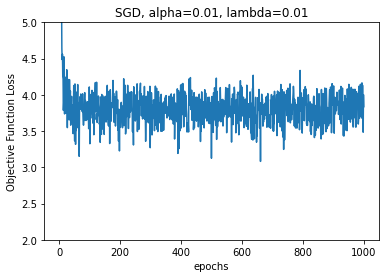

Final Training Loss: 3.8362050938723185 



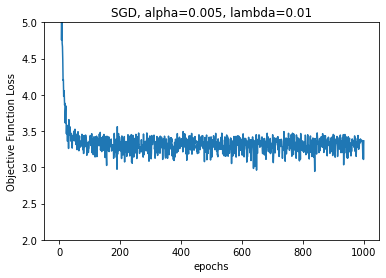

Final Training Loss: 3.3645074432127164 



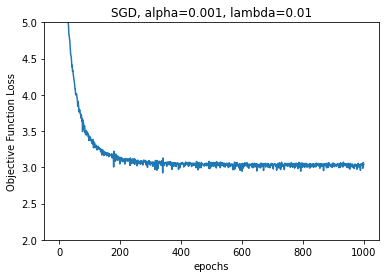

Final Training Loss: 3.0422733181941415 



In [169]:
# Run SGD with different learning rates
lamb = 0.01 # we are using optimal regularization parameter found from last blog post
    
# try a few step sizes
alphas = [0.01, 0.005, 0.001]
for alpha in alphas:
    loss_hist_train = stochastic_grad_descent(X_train, y_train, alpha=alpha, lambda_reg=lamb)[1]       
    plt.xlabel('epochs')
    plt.ylabel('Objective Function Loss')
    plt.ylim(bottom=2, top=5)
    plt.title('SGD, alpha=%s, lambda=%s' % (str(alpha), str(lamb)))
    plt.plot([i for i in range(1, 1000+1)], loss_hist_train.mean(axis=1))
    plt.show()
    print("Final Training Loss: %s \n" % (str(loss_hist_train.mean(axis=1)[-1])))